In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

def generate_creative_test_data():
    # Creative variants
    creative_types = [
        'Static_Image_v1', 'Static_Image_v2', 
        'Video_15s_v1', 'Video_15s_v2',
        'Carousel_v1', 'Carousel_v2',
        'Dynamic_v1', 'Dynamic_v2'
    ]
    
    # Placement types
    placements = ['Feed', 'Stories', 'Reels']
    
    # Date range for the test (30 days)
    dates = pd.date_range(start='2024-01-01', end='2024-01-30', freq='D')
    
    data = []
    
    for creative in creative_types:
        for placement in placements:
            # Base metrics with realistic variations
            base_reach = np.random.normal(5000, 500)  # Base unique users reached
            base_frequency = np.random.normal(2.0, 0.2)  # Average times each user sees the ad
            base_ctr = np.random.normal(0.02, 0.003)
            base_conv_rate = np.random.normal(0.05, 0.01)
            base_revenue_per_conv = np.random.normal(50, 10)
            base_cpc = np.random.normal(0.5, 0.1)
            
            # Add variation based on creative type
            if 'Video' in creative:
                base_ctr *= 1.2
                base_conv_rate *= 1.1
                base_frequency *= 0.9  # Videos typically shown less frequently
            elif 'Carousel' in creative:
                base_ctr *= 1.1
                base_revenue_per_conv *= 1.2
                base_frequency *= 1.1  # Carousels might get more impressions per user
            elif 'Dynamic' in creative:
                base_conv_rate *= 1.2
                base_cpc *= 0.9
                base_frequency *= 1.2  # Dynamic ads often shown more frequently
                
            # Add placement effects
            if placement == 'Stories':
                base_ctr *= 1.1
                base_cpc *= 0.9
                base_frequency *= 0.8  # Stories typically have lower frequency
            elif placement == 'Reels':
                base_ctr *= 1.3
                base_cpc *= 1.1
                base_frequency *= 1.1  # Reels might get more impressions per user
            
            for date in dates:
                # Daily variation
                daily_reach = int(np.random.normal(base_reach, base_reach * 0.1))
                daily_frequency = max(1, np.random.normal(base_frequency, base_frequency * 0.1))
                daily_impressions = int(daily_reach * daily_frequency)
                daily_ctr = max(0, np.random.normal(base_ctr, base_ctr * 0.1))
                daily_clicks = int(daily_impressions * daily_ctr)
                daily_conv_rate = max(0, np.random.normal(base_conv_rate, base_conv_rate * 0.1))
                daily_conversions = int(daily_clicks * daily_conv_rate)
                daily_cpc = max(0.1, np.random.normal(base_cpc, base_cpc * 0.1))
                daily_cost = daily_clicks * daily_cpc
                daily_revenue_per_conv = max(0, np.random.normal(base_revenue_per_conv, base_revenue_per_conv * 0.1))
                daily_revenue = daily_conversions * daily_revenue_per_conv
                
                row = {
                    'date': date.strftime('%Y-%m-%d'),
                    'creative_name': creative,
                    'placement': placement,
                    'reach': daily_reach,
                    'frequency': round(daily_frequency, 2),
                    'impressions': daily_impressions,
                    'clicks': daily_clicks,
                    'ctr': round(daily_ctr * 100, 3),
                    'conversions': daily_conversions,
                    'conversion_rate': round(daily_conv_rate * 100, 3),
                    'cpc': round(daily_cpc, 2),
                    'cost': round(daily_cost, 2),
                    'revenue': round(daily_revenue, 2),
                    'roas': round(daily_revenue / daily_cost if daily_cost > 0 else 0, 2),
                    'cpa': round(daily_cost / daily_conversions if daily_conversions > 0 else 0, 2),
                    'revenue_per_conversion': round(daily_revenue_per_conv, 2),
                    'engagement_rate': round((daily_clicks + np.random.randint(10, 100)) / daily_impressions * 100, 3),
                    'add_to_cart': int(daily_conversions * np.random.normal(2.5, 0.3))
                }
                data.append(row)
    
    creative = pd.DataFrame(data)
    return creative

# Generate data
creative = generate_creative_test_data()

# Save to CSV
creative.to_csv('creative_testing_data.csv', index=False)

In [3]:
creative.head()


,date,creative_name,placement,reach,frequency,impressions,clicks,ctr,conversions,conversion_rate,cpc,cost,revenue,roas,cpa,revenue_per_conversion,engagement_rate,add_to_cart
0,2024-01-01,Static_Image_v1,Feed,6077,2.12,12905,269,2.091,18,6.877,0.45,122.26,817.90,6.69,6.79,45.44,2.743,45
1,2024-01-02,Static_Image_v1,Feed,5023,1.87,9380,203,2.169,13,6.668,0.44,89.32,628.39,7.04,6.87,48.34,2.292,32
2,2024-01-03,Static_Image_v1,Feed,5467,2.14,11680,248,2.130,16,6.504,0.48,119.32,813.22,6.82,7.46,50.83,2.277,43
3,2024-01-04,Static_Image_v1,Feed,4670,2.20,10251,233,2.276,14,6.271,0.42,98.18,704.99,7.18,7.01,50.36,2.419,32
4,2024-01-05,Static_Image_v1,Feed,5417,1.70,9195,157,1.716,9,5.842,0.48,76.12,442.83,5.82,8.46,49.20,1.968,22


In [4]:
# Print basic statistics and calculate p-values between variants
print("Dataset Statistics:")
print("-" * 50)
print(f"Total records: {len(creative)}")
print("\nMetrics by Creative Type:")
print(creative.groupby('creative_name').agg({
    'reach': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum',
    'revenue': 'sum',
    'ctr': 'mean',
    'frequency': 'mean',
    'roas': 'mean'
}).round(2))

# Calculate p-values for key metrics between variants
from scipy import stats

def calculate_pvalues(creative, metric):
    """Calculate p-values between variants for a given metric"""
    results = []
    variants = creative['creative_name'].unique()
    
    for v1 in variants:
        for v2 in variants:
            if v1 < v2 and v1.split('_v')[0] == v2.split('_v')[0]:
                stat, pval = stats.ttest_ind(
                    creative[creative['creative_name'] == v1][metric],
                    creative[creative['creative_name'] == v2][metric]
                )
                results.append({
                    'variant_1': v1,
                    'variant_2': v2,
                    'metric': metric,
                    'p_value': pval
                })
    
    return pd.DataFrame(results)

# Calculate p-values for key metrics
metrics = ['ctr', 'conversion_rate', 'roas', 'frequency']
all_pvalues = pd.concat([calculate_pvalues(creative, metric) for metric in metrics])

print("\nStatistical Significance Tests (p-values):")
print(all_pvalues[all_pvalues['p_value'] < 0.05])

Dataset Statistics:
--------------------------------------------------
Total records: 720

Metrics by Creative Type:
                  reach  impressions  clicks  conversions   revenue   ctr  \
creative_name                                                               
Carousel_v1      447703      1009745   26323         1510  75618.60  2.56   
Carousel_v2      488273      1052802   25612         1040  60581.68  2.43   
Dynamic_v1       409207      1060457   22444         1029  47037.77  2.14   
Dynamic_v2       428417       961442   24283         1509  68477.54  2.51   
Static_Image_v1  481094       878395   20979         1104  54868.52  2.40   
Static_Image_v2  440042       824950   17038          809  36261.37  2.13   
Video_15s_v1     393587       717832   20257         1236  64473.84  2.82   
Video_15s_v2     473610       743650   19844          974  48868.52  2.68   

                 frequency  roas  
creative_name                     
Carousel_v1           2.28  6.06  
Carouse

Static Image A/B Test Results:
            Metric    V1_Mean    V2_Mean     Lift  P_Value
0      impressions  9759.9444  9166.1111  -6.0844   0.0164
1           clicks   233.1000   189.3111 -18.7855   0.0000
2      conversions    12.2667     8.9889 -26.7210   0.0000
3          revenue   609.6502   402.9041 -33.9123   0.0000
4             cost   123.6378    86.5821 -29.9712   0.0000
5              ctr     2.3987     2.1279 -11.2897   0.0000
6  conversion_rate     5.4642     5.1805  -5.1912   0.1525
7             roas     5.3087     5.0784  -4.3367   0.4222


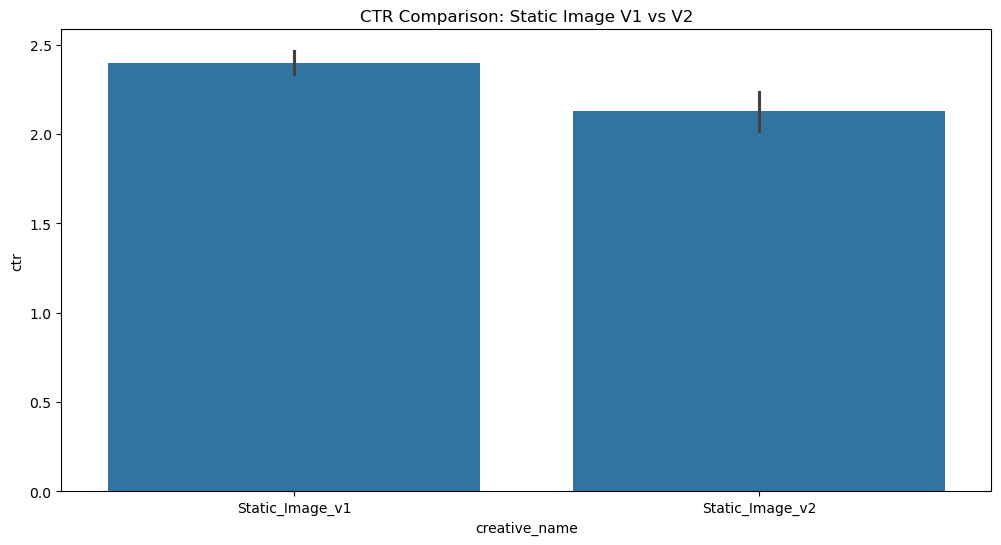

In [5]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load and filter data for Static Image variants
static_data = creative[creative['creative_name'].str.contains('Static_Image')]
v1_data = static_data[static_data['creative_name'] == 'Static_Image_v1']
v2_data = static_data[static_data['creative_name'] == 'Static_Image_v2']

# Compare key metrics
metrics = ['impressions', 'clicks', 'conversions', 'revenue', 'cost', 'ctr', 'conversion_rate', 'roas']

# Calculate statistics
stats_comparison = pd.DataFrame({
    'Metric': metrics,
    'V1_Mean': [v1_data[metric].mean() for metric in metrics],
    'V2_Mean': [v2_data[metric].mean() for metric in metrics],
    'Lift': [((v2_data[metric].mean() / v1_data[metric].mean()) - 1) * 100 for metric in metrics],
    'P_Value': [stats.ttest_ind(v1_data[metric], v2_data[metric]).pvalue for metric in metrics]
})

print("Static Image A/B Test Results:")
print(stats_comparison.round(4))

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=static_data, x='creative_name', y='ctr')
plt.title('CTR Comparison: Static Image V1 vs V2')
plt.show()


if p_value < 0.05:
    # Only then look at lift and other metrics
    analyze_lift_and_performance()
else:
    return "Results not statistically significant"


1. Check P-value
   ├── If p ≥ 0.05: Stop (results inconclusive)
   └── If p < 0.05: Continue to step 2

2. Check Lift
   ├── If lift > minimum threshold: Winner
   └── If lift < minimum threshold: Small effect

3. Check Sample Size
   ├── If sufficient: Implement decision
   └── If insufficient: Need more data

In [6]:
creative.head

<bound method NDFrame.head of            date    creative_name placement  reach  frequency  impressions  \
0    2024-01-01  Static_Image_v1      Feed   6077       2.12        12905   
1    2024-01-02  Static_Image_v1      Feed   5023       1.87         9380   
2    2024-01-03  Static_Image_v1      Feed   5467       2.14        11680   
3    2024-01-04  Static_Image_v1      Feed   4670       2.20        10251   
4    2024-01-05  Static_Image_v1      Feed   5417       1.70         9195   
..          ...              ...       ...    ...        ...          ...   
715  2024-01-26       Dynamic_v2     Reels   4449       3.16        14078   
716  2024-01-27       Dynamic_v2     Reels   3629       1.97         7162   
717  2024-01-28       Dynamic_v2     Reels   4435       2.72        12084   
718  2024-01-29       Dynamic_v2     Reels   4294       2.76        11857   
719  2024-01-30       Dynamic_v2     Reels   4902       2.58        12663   

     clicks    ctr  conversions  conversion_r

In [9]:
creative_totals = creative.groupby('creative_name').agg({"impressions": "sum", "clicks": "sum", "conversions": "sum", "revenue": "sum", "cost": "sum"})
creative_totals

,impressions,clicks,conversions,revenue,cost
creative_name,,,,,
Carousel_v1,1009745,26323,1510,75618.60,12442.64
Carousel_v2,1052802,25612,1040,60581.68,13086.30
Dynamic_v1,1060457,22444,1029,47037.77,11479.23
Dynamic_v2,961442,24283,1509,68477.54,9014.50
Static_Image_v1,878395,20979,1104,54868.52,11127.40
Static_Image_v2,824950,17038,809,36261.37,7792.39
Video_15s_v1,717832,20257,1236,64473.84,11055.03
Video_15s_v2,743650,19844,974,48868.52,9331.09


In [10]:
creative_totals = creative.groupby('placement').agg({"impressions": "sum", "clicks": "sum", "conversions": "sum", "revenue": "sum", "cost": "sum"})
creative_totals

,impressions,clicks,conversions,revenue,cost
placement,,,,,
Feed,2547402,54164,2911,143996.84,24552.36
Reels,2569133,68433,3786,184284.97,35258.90
Stories,2132738,54183,2514,127906.03,25517.32


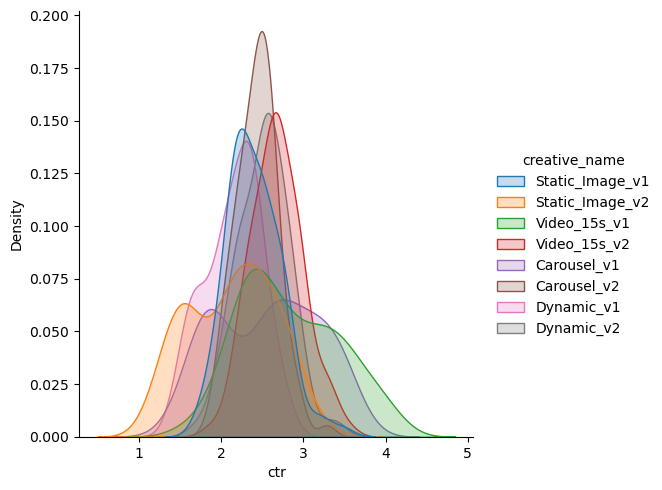

In [12]:
sns.displot(creative, x="ctr", hue="creative_name", kind="kde", fill=True)